In [337]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [338]:
total_data = pd.read_csv('articles_data.csv')

In [339]:
len(total_data)

10437

In [340]:
data = total_data.drop(['Unnamed: 0', 'url', 'url_to_image'], axis=1).reset_index(drop=True)

# Problem Definition

I would like to predict the probability of any given article being completely ignored by people, ending up with zero comments, zero reactions, and zero shares.

I will try to different methods to see if we can differentiate these articles from others which do get at least some attention: using FastText and using the good-old Bag of Words method TF-IDF.

## The Target (ignored articles)

In [341]:
data.rename(columns={'engagement_reaction_count': 'reactions'}, inplace=True)

In [342]:
data.rename(columns={'engagement_comment_count': 'comments'}, inplace=True)

In [343]:
data.rename(columns={'engagement_share_count': 'shares'}, inplace=True)

In [344]:
len(data[(data['reactions'].isna()) | (data['shares'].isna()) | (data['comments'].isna())]) / len(data)

0.011305930823033439

We have only 1% NaN values in our targets. Let's just drop these articles.

In [345]:
data = data[~data['reactions'].isna()].reset_index(drop=True)

In [346]:
data = data[~data['shares'].isna()].reset_index(drop=True)

In [347]:
data = data[~data['comments'].isna()].reset_index(drop=True)

In [348]:
len(data[(data['reactions']==0) & (data['shares']==0) & (data['comments']==0)]) / len(data)

0.2408179087120845

24% of the articles have been completely ignored by the public and got lost in the immensity of the internet without getting any reaction, comment, or share :(

These are the articles we will try to predict with our model.

In [349]:
data['label'] = [1 if (x==0) & (y==0) & (z==0) else 0 for x,y,z in zip(data.shares, data.comments, data.reactions)]

In [350]:
data['total_engagements'] = data['shares'] +  data['reactions'] + data['comments']

In [351]:
data['category'] = ['Zero Engagements (Our Target)' if x==0 else 'Between 0 & 10 Engagements' if x<10 else \
                   'Between 10 & 25 Engagements' if x<25 else 'Between 25 & 50 Engagements' if x<50 else \
                   'Between 50 & 100 Engagements' if x<100 else 'Between 100 & 500 Engagements' if x<500 else \
                    'More than 500 Engagements' for x in data.total_engagements]

In [352]:
data['category'] = pd.Categorical(data['category'], ['Zero Engagements (Our Target)', 'Between 0 & 10 Engagements', \
                             'Between 10 & 25 Engagements', 'Between 25 & 50 Engagements', \
                             'Between 50 & 100 Engagements', 'Between 100 & 500 Engagements', \
                             'More than 500 Engagements'])

pie = data[['category', 'title']].groupby('category', as_index=False).count().rename(columns={'title': 'count'})
pie.sort_values('category', inplace=True)

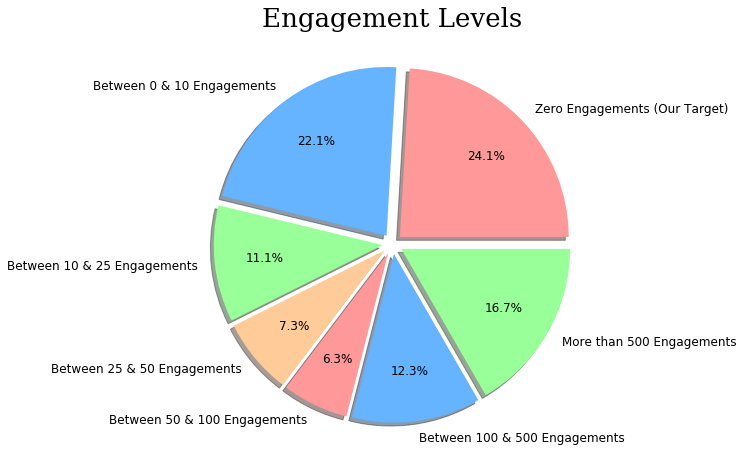

In [353]:
fig, ax = plt.subplots(figsize=[10,10])
labels = pie['category']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(x=pie['count'], autopct="%.1f%%", labels=labels, explode=[0.06]*7, pctdistance=0.7, colors=colors, shadow=True, \
       textprops=dict(fontsize=12))
plt.title("Engagement Levels", fontsize=26, fontfamily='serif')
plt.tight_layout()
plt.show()

It seems that the distribution of total engagements is completely weird and would be hard to predict in a regression. 

46% of the articles have less than 10 engagements, and 30% of the articles have more than 100 engagmements!

Together they cover more than 75% of the total articles, so it appears that that most articles either provoke little to none engagement, or they go kind of viral with hundreds of engagements. There's not much middle ground.

# Data Cleaning/Manipulation

## Handle Dates

I will extract some info from the date field, mostly because I want to later divide training and testing sets temporarly (train up to a certain date, test after that date)

In [354]:
from datetime import datetime
import re

In [355]:
compiler = re.compile("[0-9-]+")

In [356]:
data['date'] = [compiler.findall(x)[0] for x in data.published_at]

In [357]:
data['hour'] = [compiler.findall(x)[1] for x in data.published_at]

In [358]:
data['month'] = [datetime.strptime(x, '%Y-%m-%d').month for x in data.date]

In [359]:
data['week_day'] = [datetime.strptime(x, '%Y-%m-%d').weekday() for x in data.date]

In [360]:
data['week_day'] = ['Monday' if x==0 else 'Tuesday' if x==1 else 'Wednesday' if x==2 else 'Thursday' if x==3 else \
                   'Friday' if x==4 else 'Saturday' if x==5 else 'Sunday' for x in data.week_day]

## Text Cleaning

We fix np.NaNs in our text fields.

In [361]:
data.author.fillna('Unknown Author', inplace=True)

In [362]:
data.title.fillna('', inplace=True)

In [363]:
data.description.fillna('', inplace=True)

In [364]:
data.content.fillna('', inplace=True)

In [365]:
data.top_article = data.top_article.astype(int)

In [366]:
data['Top_Article_Text'] = ['Top Article! ' if x==1 else '' for x in data.top_article]

We concatenate all useful fields into one columns named Text. FastText will know how to handle everything together.

In [367]:
data['text'] = data['Top_Article_Text'] + ' ' + data['source_name'] + ' ' + data['author'] + ' ' + data['title'] + ' ' + data['description'] +  ' ' + data['content'] +  ' ' + data['week_day'] + ', ' + data['hour'].astype(str) + 'hs.'

Now let us remove stop-words from the articles and fix the nasty stuff such as html text and other things that need cleaning (clean_text function).

In [368]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

In [369]:
def clean_text(column):
    articles=column.copy()
    compiler = re.compile("[\w'#:/%]+")
    compiler_fix_html = re.compile("[^\w'.,#! ][rnstbc]")
    all_texts=[]
    for text in articles:
        this_text=str()
        text = re.sub("(https|http)?(:\/\/)?(www.)", '' , text)
        text = re.sub("</li><li>", '' , text)
        text = re.sub("</li><li…", '' , text)
        text = re.sub("(.com)", ' ' , text)
        text = re.sub("/[\w]+ ", '', text)
        text = re.sub("(<table>)", '', text)
        text = re.sub("(<tr>)", '', text)
        text = re.sub("(</tr>)", '', text)
        text = re.sub("(<td>)", '', text)
        text = re.sub("(</td>)", '', text)
        #text = re.sub("'s", '', text)
        for word in compiler.findall(text.lower()):
            if word in stopWords: continue
            this_text+=word
            this_text+=' '
        for html_text in compiler_fix_html.findall(text):
            text.replace(html_text, '')
        all_texts.append(this_text)
    articles=all_texts
    return articles

In [370]:
cleaned_text = clean_text(data.text)

In [371]:
from random import randrange
rand = randrange(200)
print('Original: \n', data['text'][rand])
print('\n')
print('Cleaned: \n', cleaned_text[rand])

Original: 
  The Irish Times David Hytner Arsenal defence makes balance hard to come by They’ve made 13 errors leading to goals in the Premier League since start of last season It is not the sort of admission with which a member of the goalkeepers union ought to be comfortable. In the throes of a discussion about Arsenals identity, Bernd Leno was asked whether his team were the sort who backed themselves to outscore all comers. Yes,… [+5106 chars] Tuesday, 10hs.


Cleaned: 
 irish times david hytner arsenal defence makes balance hard e made 13 errors leading goals premier league since start last season sort admission member goalkeepers union ought fortable throes discussion arsenals identity bernd leno asked whether team sort backed outscore ers yes 5106 chars tuesday 10hs 


Well, I actually think that the uncleaned version looks nicer than the cleaned version of the text. But FastText really prefers the latter, so I won't argue with it.

In [372]:
data['text'] = clean_text(data.text)

# Words Cloud

Let's take a quick look just to see which words are most frequently used in Headlines and within the Articles' content.

In [373]:
import wordcloud
from wordcloud import WordCloud

In [374]:
titles=str()
for text in data.title:
    for word in compiler.findall(text.lower()):
        if word in stopWords: continue
        titles+=text
titles = titles.replace('GMT2019','')

In [375]:
wordcloud = WordCloud(background_color='ghostwhite').generate(titles)

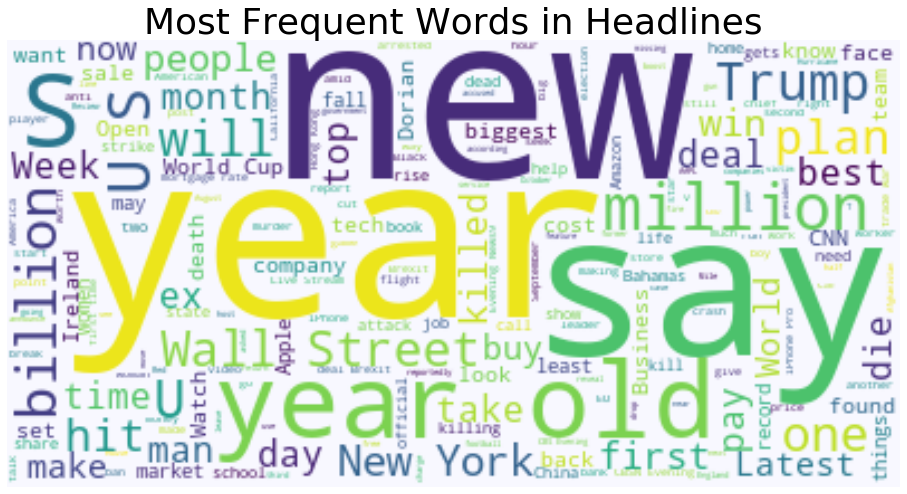

In [376]:
fig, ax = plt.subplots(figsize=(16,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Headlines", fontsize=36)
plt.show()

In [378]:
contents =str()
for text in data.content:
    for word in compiler.findall(text.lower()):
        if word in stopWords: continue
        contents+=text
contents = contents.replace('chars','')
contents = contents.replace('said','')
contents = contents.replace('say','')
contents = contents.replace('tr','')
contents = contents.replace('td','')
contents = contents.replace('one','')

In [379]:
wordcloud = WordCloud(background_color='salmon', min_font_size=4).generate(contents)

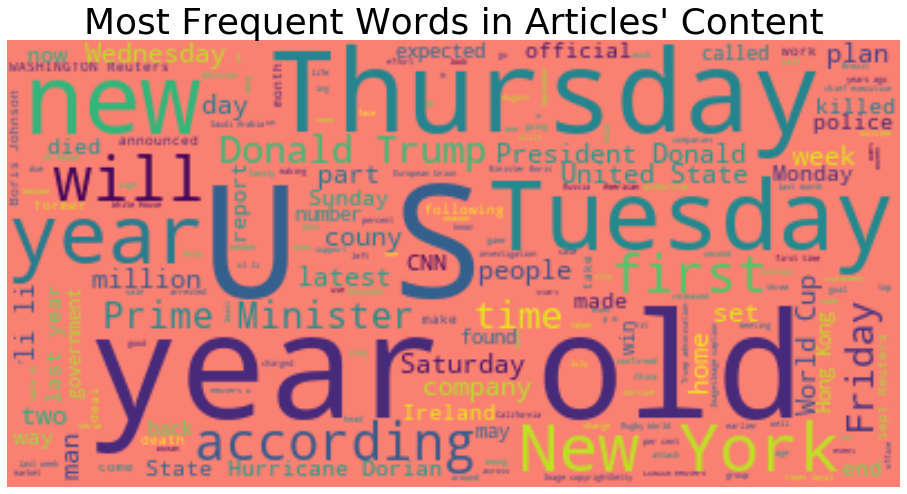

In [380]:
fig, ax = plt.subplots(figsize=(16,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Articles' Content", fontsize=36)
plt.show()

# Model 1: FastText

I will use the data from September, 2019 to train the model, and data from October, 2019 to test it. It makes sense from a practical point of view to do it this way (train with the past, predict the future). It is a more realistic scenario.

In [381]:
train_df = data[data['month']==9].reset_index(drop=True)
test_df = data[data['month']==10].reset_index(drop=True)

In [382]:
len(test_df) / len(data)

0.21998255644926834

We have 21% of the data for testing then. Seems reasonable.

In [383]:
X_train = train_df.text.tolist()
X_test = test_df.text.tolist()

y_train = train_df.label
y_test = test_df.label

In [384]:
# This function creates a file that can serve as input to FastText (we need the __label__ stuff before every data-point)
def create_file(x, y, fname):
    with open(fname, 'w', encoding='utf=8') as f:
        for i, x_i in enumerate(x):
            if i > 0: f.write('\n')
            f.write(f'__label__{y[i]} {x_i}')

In [385]:
create_file(X_train, y_train.tolist(), 'train.data')

In [386]:
def predict(model, X):
    probs=[]
    for labels, scores in zip(*model.predict(X, k=2)):
        probs.append(dict(zip(labels, scores))['__label__1'])
    return probs

Let us use Hyperopt to properly tune the FastText hyper-parameters. Results from FastText are actually very sensitive to the tuning of these parameters, so this part is important. You can refer to FastText documentation to know what everything means, but the docs are hard to find and not very informative, so here goes a quick summary:

- Learning Rate and Epoch: allow us to prevent overfitting by not giving enough time for the model to learn "too much" from the training data.
- minCount: minimum number of times a word or ngram must appear in the data before being considered.
- minn & maxn: minimum number of characters to form a character-n-gram. This allows FastText to take into account also the stems of words, and realize, for example, that "banana" and "bananas" are the same. If maxn<minn, then FastText won't use character ngrams and consider entire words only.
- dim: the dimension of the vector that will represent each word.
- loss: the loss function, three options: softmax, hierarchical softmax, and negative samples.

In [387]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, fbeta_score
import fasttext

def evaluate_model(params):
   
    model_ftext = fasttext.train_supervised(input='train.data',  
                                            minCount=params['minCount'], 
                                            lr=params['lr'], 
                                            wordNgrams=params['wordNgrams'], 
                                            minn=params['minn'], 
                                            maxn=params['maxn'], 
                                            dim=params['dim'], 
                                            epoch=params['epoch'], 
                                            loss=params['loss_func']
                                           )
    predictions = [1 if x>=0.5 else 0 for x in predict(model_ftext, list(X_test))]
    
    return {
        'minCount': params['minCount'],
        'wordNgrams': params['wordNgrams'],
        'learning_rate': params['lr'],
        'minn': params['minn'],
        'maxn': params['maxn'],
        'dim': params['dim'],
        'epoch': params['epoch'],
        'loss_func': params['loss_func'],
        'Train_AUC': round(roc_auc_score(y_train, predict(model_ftext, list(X_train))), 3),
        'Test_AUC': round(roc_auc_score(y_test, predict(model_ftext, list(X_test))), 3),
        'Train_PR': round(average_precision_score(y_train, predict(model_ftext, list(X_train))), 3),
        'Test_PR': round(average_precision_score(y_test, predict(model_ftext, list(X_test))), 3),
        'Precision': round(precision_score(y_test, predictions), 3),
        'Recall': round(recall_score(y_test, predictions), 3),         
        }

def objective(params):
    res = evaluate_model(params)
    res['loss'] = - res['Test_AUC']
    res['status'] = STATUS_OK
    return res 

hyperparameter_space = {
        'minCount': hp.choice('minCount', range(1, 10)),
        'lr': hp.uniform('lr',0.1, 0.3),
        'wordNgrams': hp.choice('wordNgrams', range(1, 3)),
        'dim': hp.choice('dim', range(5, 300)),
        'epoch': hp.choice('epoch', range(4, 8)),
        'loss_func': hp.choice('loss_func', ['hs', 'softmax', 'ns']),
        'minn': hp.choice('minn', range(3, 8)),
        'maxn': hp.choice('maxn', range(3,8))
        }

In [388]:
trials = Trials()
best = fmin(
    objective,
    space=hyperparameter_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
);

100%|██████████████████████████████████████████████████████████| 100/100 [08:49<00:00,  5.30s/trial, best loss: -0.871]


In [1054]:
experiment_results = pd.DataFrame(trials.results)
experiment_results.sort_values(by='loss').head(10)

,minCount,wordNgrams,learning_rate,minn,maxn,dim,epoch,loss_func,Train_AUC,Test_AUC,Train_PR,Test_PR,Precision,Recall,loss,status
79,9,2,0.249091,5,4,76,6,softmax,0.997,0.871,0.991,0.713,0.747,0.455,-0.871,ok
54,6,2,0.249711,6,5,50,5,softmax,0.993,0.871,0.979,0.711,0.737,0.441,-0.871,ok
65,8,2,0.297864,7,5,253,5,softmax,0.996,0.871,0.988,0.711,0.743,0.457,-0.871,ok
72,8,2,0.283109,7,5,158,5,softmax,0.995,0.871,0.986,0.713,0.738,0.449,-0.871,ok
25,8,2,0.278639,7,5,104,5,softmax,0.995,0.871,0.985,0.713,0.743,0.457,-0.871,ok
83,9,2,0.211681,5,4,208,6,softmax,0.994,0.871,0.982,0.713,0.726,0.468,-0.871,ok
71,8,2,0.282881,6,5,133,5,softmax,0.995,0.871,0.986,0.710,0.728,0.469,-0.871,ok
93,1,2,0.294925,7,5,237,5,softmax,0.996,0.870,0.988,0.712,0.738,0.453,-0.870,ok
26,8,2,0.278384,7,5,50,5,softmax,0.995,0.870,0.986,0.712,0.741,0.460,-0.870,ok
27,8,2,0.294004,7,5,104,5,softmax,0.996,0.870,0.989,0.712,0.745,0.450,-0.870,ok


We can get a ROC-AUC as high as 86% in the testing set, which is very decent, I would even say it's good!
Instead of picking the best model, I'd rather go with model from Trial #9 though, as it overfits a little bit less (still seems to overfit though) and sacrifices a bit of Precision but improves Recall a lot.

I would prefer for this case to value Precision over Recall. That is, I prefer my model to be right most of the times when it says that an article will be ignored, and don't mind as much if it predicts that it will be ignored but in the end it's not (which is what Recall measures). But since we can increase Recall 20% by sacrificing 10% on Precision and still be on 74% on the latter, I make this decision.

In [277]:
import fasttext
model_ftext = fasttext.train_supervised(input='train.data',  
                                        minCount=9, 
                                        lr=0.25, 
                                        wordNgrams=2, 
                                        minn=5, 
                                        maxn=4, 
                                        dim=76, 
                                        epoch=6, 
                                        loss='softmax')

In [959]:
# Original Precision 72% Recall 40%
model_ftext = fasttext.train_supervised(input='train.data',  
                                        minCount=8, 
                                        lr=0.29, 
                                        wordNgrams=2, 
                                        minn=4, 
                                        maxn=3, 
                                        dim=197, 
                                        epoch=4, 
                                        loss='hs')

In [278]:
predictions=pd.DataFrame()
predictions['source']=test_df['source_name']
predictions['title']=test_df['title']
predictions['shares']=test_df['shares']
predictions['label']=test_df['label']
predictions['predictions'] = predict(model_ftext, list(X_test))

In [279]:
predictions['Ignored'] = [1 if x>=0.5 else 0 for x in predictions.predictions]

In [280]:
predictions['correct'] = [1 if x==y else 0 for x,y in zip(predictions.Ignored, predictions.label)]

In [281]:
predictions.sample(10)

,source,title,shares,label,predictions,Ignored,correct
1245,The New York Times,"In Houston, a Rash of Storms Test the Limits o...",66.0,0,0.159215,0,1
403,CNN,"At least one dead, several injured in 'violent...",610.0,0,0.000225,0,1
850,ABC News,Investigators seek email from ex-University of...,0.0,1,0.696702,1,1
241,The New York Times,Love and War in European Fiction,9.0,0,0.045591,0,1
1378,The Wall Street Journal,Samsung Galaxy Fold Review: The $2000 Phone of...,44.0,0,0.064567,0,1
131,Business Insider,"Spies, suicide, and a clash at a cocktail part...",1593.0,0,0.005334,0,1
1773,ABC News,Defense expert: Officer justified in shooting ...,0.0,1,0.654986,1,1
2255,CNN,This moon outside of the solar system isn't an...,15.0,0,0.030209,0,1
2165,The Irish Times,Rugby World Cup: Ireland backrow faces further...,1.0,0,0.213544,0,1
969,BBC News,Blenheim Palace gold toilet theft: 'Substantia...,6.0,0,0.005347,0,1


In [282]:
predictions.correct.mean()

0.8079295154185022

In [283]:
# PRECISION
len(predictions[(predictions['Ignored']==1) & (predictions['correct']==1)]) / len(predictions[predictions['Ignored']==1])

0.7336683417085427

In [284]:
# RECALL
len(predictions[(predictions['Ignored']==1) & (predictions['correct']==1)]) / len(predictions[predictions['label']==1])

0.4694533762057878

In [285]:
len(predictions[predictions['Ignored']==1])

398

In [286]:
len(predictions[predictions['Ignored']==0])

1872

In [287]:
train_preds_fasttext = predict(model_ftext, list(X_train))

In [288]:
test_preds_fasttext = predict(model_ftext, list(X_test))

## Playing with examples from real news

What's cool about this is that we can actually input the text we want and get a response regarding the probability of our article being ignored with zero comments, shares and reactions. Let's try a couple of examples of real articles taken from CNN website.

In [64]:
def predict_my_article(source, title, content, week_day):
    string = source + ' ' + title + ' ' + content + ' ' + week_day
    compiler = re.compile("[\w'#:/%]+")
    this_text=str()
    result_string=[]
    for word in compiler.findall(string.lower()):
        if word in stopWords: continue
        this_text+=word
        this_text+=' '
    result_string.append(this_text)
    result = predict(model_ftext, list(result_string))
    print(color.BOLD + '\n Your article has a {}% chance of being completely ignored by the public'.format(round(result[0]*100,2)) + color.END)

In [65]:
source = input(color.BOLD + "Type the Source of the Article: \n" + color.END)
print('\n')
title = input(color.BOLD + "Type the Title of the Article: \n" + color.END)
print('\n')
content= input(color.BOLD + "Type the content of the Article: \n" + color.END)
print('\n')
week_day = input(color.BOLD + "Input the day of the week in which it will be published: \n" + color.END)
print('\n')
predict_my_article(source, title, content, week_day)

Type the Source of the Article: 
CNN


Type the Title of the Article: 
Florida police raid home of former state Covid-19 data scientist


Type the content of the Article: 
Florida police raided the home of a former state coronavirus data scientist on Monday, escalating a feud between the state government and a data expert who has accused officials of trying to cover up the extent of the pandemic.  The Florida Department of Law Enforcement executed a search warrant Monday morning at the home of data scientist Rebekah Jones, who was fired by the state Department of Health in May. The agency is investigating whether Jones accessed a state government messaging system without authorization to urge employees to speak out about coronavirus deaths, according to an affidavit by an agent working on the case. Jones told CNN that she hadn't improperly accessed any state messaging system and that she lost access to her government computer accounts after she was removed from her position. About 10 o

In [66]:
source = input(color.BOLD + "Type the Source of the Article: \n" + color.END)
print('\n')
title = input(color.BOLD + "Type the Title of the Article: \n" + color.END)
print('\n')
content= input(color.BOLD + "Type the content of the Article: \n" + color.END)
print('\n')
week_day = input(color.BOLD + "Input the day of the week in which it will be published: \n" + color.END)
print('\n')
predict_my_article(source, title, content, week_day)

Type the Source of the Article: 
CNN


Type the Title of the Article: 
Is an alleged drug kingpin from China investing millions in a port in Laos?


Type the content of the Article: 
On October 6, news of a $50 million dollar investment to build a port in the Laotian town of Ban Mom led the business section of the Vientiane Times, a prominent state-run newspaper. In the second paragraph, readers were told that a man named Zhao Wei participated in a groundbreaking ceremony for the project. +1000 characters


Input the day of the week in which it will be published: 
Sunday



 Your article has a 1.44% chance of being completely ignored by the public


Now to understand what the model is doing, let's try the exact same article as before but changing CNN as source to, let's say, La Nacion, an Argentinian newspaper that the model has never seen before. Additionally, let's remove the words "Drug Kingpin from China" from the title, which I suppose are attractive words that prevent people from ignoring this article. If the model behaves more or less the way I suspect, then it should return a higher probability of the article being ignored.

In [69]:
source = input(color.BOLD + "Type the Source of the Article: \n" + color.END)
print('\n')
title = input(color.BOLD + "Type the Title of the Article: \n" + color.END)
print('\n')
content= input(color.BOLD + "Type the content of the Article: \n" + color.END)
print('\n')
week_day = input(color.BOLD + "Input the day of the week in which it will be published: \n" + color.END)
print('\n')
predict_my_article(source, title, content, week_day)

Type the Source of the Article: 
La Nacion


Type the Title of the Article: 
Is an alleged from investing millions in a port in Laos?


Type the content of the Article: 
On October 6, news of a $50 million dollar investment to build a port in the Laotian town of Ban Mom led the business section of the Vientiane Times, a prominent state-run newspaper. In the second paragraph, readers were told that a man named Zhao Wei participated in a groundbreaking ceremony for the project. +1000 characters


Input the day of the week in which it will be published: 
Sunday



 Your article has a 5.14% chance of being completely ignored by the public


Indeed we went up to 5% chance of being ignored!

# Model 2: Bag of Words TF-IDF

In [290]:
from collections import Counter
import re
compiler = re.compile("[\w]+")
count_dict = Counter()

We first count Document Frequency. That is the number of articles in which each word appears.

In [292]:
doc_freq = Counter()
for article in data.text:
    for word in compiler.findall(article.lower()):
        doc_freq[word] += 1
        article = article.replace(word, '')

Now we count Term Frequency. That is the number of times each word appears on each article.

In [293]:
tf=dict()
for i, article in zip(data.index, data.text):
    term_freq = Counter()
    for word in compiler.findall(article.lower()):
        term_freq[word] += 1 
    tf[i]= term_freq

In [294]:
articles=[]; words=[]; t_freq=[]; d_freq=[]
for article_n in tf:
    for word in tf[article_n]:
        if doc_freq[word] > len(data)*0.2: continue
        if doc_freq[word]<10: continue
        articles.append(article_n)
        words.append(word)
        t_freq.append(tf[article_n][word])
        d_freq.append(doc_freq[word])

In [295]:
bag_of_words = pd.DataFrame()
bag_of_words['articles']=articles
bag_of_words['word']=words
bag_of_words['tf']=t_freq
bag_of_words['df']= d_freq
bag_of_words['idf']= len(data) / bag_of_words['df']
bag_of_words['TFIDF'] = (1 + np.log(bag_of_words['tf'])) * np.log(bag_of_words['idf'])

There are different ways to calculate TF-IDF. I prefer the logarithmic option, as I did above. Also below let us remove the words that appear only once in an article. Since our articles are reasonably long, it makes sense to assume that a word appearing only once on them is not that important and we can discard it.

In [296]:
bag_of_words = bag_of_words[bag_of_words['tf']>1]

Let's inspect a few examples of what our Bag of Words is telling us:

In [297]:
data['text'][3]

"bbc news bbc news uk government lawyer says proroguing parliament 'political legal' uk government's lawyer david johnston argued proroguing parliament political decision government rather legal matter court decide tuesday 14hs "

In [298]:
bag_of_words[bag_of_words['articles']==3].sort_values('TFIDF', ascending=False)

,articles,word,tf,df,idf,TFIDF
108,3,lawyer,2,95,108.621053,7.937246
112,3,legal,2,150,68.793333,7.163887
110,3,parliament,2,206,50.092233,6.626751
111,3,political,2,297,34.744108,6.007303
106,3,uk,2,418,24.686603,5.428671
107,3,government,3,834,12.372902,5.279078
105,3,bbc,2,1827,5.648057,2.931365


We have the actual text of the article printed above, and then our Bag of Words tell us that Lawyer, Legal, and Parliament are the three most relevant words of that article. It makes sense. Let's see another example.

In [299]:
data['text'][25]

"al jazeera english al jazeera india's chandrayaan 2 ready moon landing indian space agency says 140m module reached distance 100km moon's surface set land saturday landing module india's unmanned moon mission separated successfully orbiter monday ahead planned touchdown moon's south polar region weekend country's space agency said systems orbiter lander 1021 chars tuesday 01hs "

In [300]:
bag_of_words[bag_of_words['articles']==25].sort_values('TFIDF', ascending=False)

,articles,word,tf,df,idf,TFIDF
790,25,moon,4,73,141.356164,11.815218
791,25,landing,2,31,332.870968,9.833384
793,25,space,2,123,83.894309,7.499893
787,25,india,2,211,48.905213,6.586146
794,25,agency,2,258,39.996124,6.245652
785,25,jazeera,2,857,12.040840,4.213065
784,25,al,2,995,10.370854,3.960270


We get moon, landing, space and India as the four most relevant words. I guess that's a perfect way to summarize this article, so very nice work.

## Using Sci-Kit Learn TF-IDF Vectorizer

Now for our actual model let's make our lives easier by making use of the module that SKLearn gives us for this purpose.

In [432]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [435]:
X_train = train_df['text']
X_test = test_df['text']

In [438]:
pipe = make_pipeline(TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=0.3, min_df=40, sublinear_tf=True), 
                     LogisticRegression())
pipe.fit(X_train, y_train)

print('Training ROC-AUC - ', round(roc_auc_score(y_train, pipe.predict_proba(X_train)[:, 1]),2))
print('Testing ROC-AUC - ', round(roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1]),2),'\n')
print('Training PR-AUC - ', round(average_precision_score(y_train, pipe.predict_proba(X_train)[:, 1]),2))
print('Testing PR-AUC - ', round(average_precision_score(y_test, pipe.predict_proba(X_test)[:, 1]),2),'\n')
print('Precision - ', round(precision_score(y_test, pipe.predict(X_test)), 2))
print('Recall - ', round(recall_score(y_test, pipe.predict(X_test)), 2)) 

Training ROC-AUC -  0.91
Testing ROC-AUC -  0.87 

Training PR-AUC -  0.77
Testing PR-AUC -  0.7 

Precision -  0.78
Recall -  0.35


So it looks like we do very decently with our old-fashioned Bag of Words method. We achieve a Test ROC-AUC higher than with FastText, even though our Recall is lower. And this was achieed with a simple linear model. Now let's see what happens if we add other features to our model that may help us predict the articles' success, such as which is the Source, whether it was labeled as Top Article by the source, the day of the week and the time of the day in which the article was released.

In [439]:
X_train = train_df[['source_name', 'text', 'top_article', 'week_day', 'hour']]

In [440]:
X_test = test_df[['source_name', 'text', 'top_article', 'week_day', 'hour']]

In [443]:
# This lets us include the TFIDF Vectorizer from above in the same pipeline as the rest, by extracting the column "text" only and put it inside the vectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
class TextOnly(BaseEstimator, TransformerMixin):

    def fit(self, X, y):
        return self
    
    def transform(self, X):
        res=[]
        for article in X.text:
            res.append(article)
        return res

In [444]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
class Sources(BaseEstimator, TransformerMixin):

    def fit(self, X, y):
        return self
    
    def transform(self, X):
        res=[]
        for source in X.source_name:
            res.append({source: 1})
        return res

In [445]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
class TopArticle(BaseEstimator, TransformerMixin):

    def fit(self, X, y):
        return self
    
    def transform(self, X):
        res=[]
        for value in X.top_article:
            res.append({'top_article': int(value)})
        return res

In [446]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
class WeekDay(BaseEstimator, TransformerMixin):

    def fit(self, X, y):
        return self
    
    def transform(self, X):
        res=[]
        for week_day in X.week_day:
            res.append({week_day: 1})
        return res

In [447]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
class Hour(BaseEstimator, TransformerMixin):

    def fit(self, X, y):
        return self
    
    def transform(self, X):
        res=[]
        for hour in X.hour:
            res.append({hour: 1})
        return res

In [474]:
from sklearn.pipeline import make_union
from sklearn.preprocessing import StandardScaler
def get_features_pipe():
    steps = []
    steps.append(make_pipeline(TextOnly(), 
                        TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=0.3, min_df=40, sublinear_tf=True)))

    steps.append(make_pipeline(Sources(), DictVectorizer(sparse=False)))
    steps.append(make_pipeline(TopArticle(), DictVectorizer(sparse=False)))
    steps.append(make_pipeline(WeekDay(), DictVectorizer(sparse=False)))
    steps.append(make_pipeline(Hour(), DictVectorizer(sparse=False)))
    res = make_union(*steps)
    return res

def get_model_pipe(features_pipe, estimator):
    return make_pipeline(features_pipe, estimator)

features_pipe=get_features_pipe()

In [475]:
pipe = get_model_pipe(
                        features_pipe,
                        estimator= LogisticRegression(max_iter=400),
                        )
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pipeline-1',
                                                 Pipeline(memory=None,
                                                          steps=[('textonly',
                                                                  TextOnly()),
                                                                 ('tfidfvectorizer',
                                                                  TfidfVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.float64'>,
                                                                                  encoding='utf-8',
             

In [476]:
print('Training ROC-AUC - ', round(roc_auc_score(y_train, pipe.predict_proba(X_train)[:, 1]),2))
print('Testing ROC-AUC - ', round(roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1]),2),'\n')
print('Training PR-AUC - ', round(average_precision_score(y_train, pipe.predict_proba(X_train)[:, 1]),2))
print('Testing PR-AUC - ', round(average_precision_score(y_test, pipe.predict_proba(X_test)[:, 1]),2),'\n')
print('Precision - ', round(precision_score(y_test, pipe.predict(X_test)), 2))
print('Recall - ', round(recall_score(y_test, pipe.predict(X_test)), 2))

Training ROC-AUC -  0.91
Testing ROC-AUC -  0.88 

Training PR-AUC -  0.78
Testing PR-AUC -  0.72 

Precision -  0.73
Recall -  0.43


It's not very clear whether anything has improved. Our Precision went down and Recall up when compared to before adding these features.

To end this notebook, we will now try these same features but fed into a more powerful and complex model than simple Logistic Regression, like a Gradient Boosting Machine.

I'll use LightGBM as the algorithm and Hyperopt once again to tune the hyperaparameters.

In [471]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, fbeta_score
import lightgbm as lgbm

def evaluate_model(params):
   
    parameters = {
                    'num_leaves':params['num_leaves'], 
                    'objective':'binary',
                    'max_depth':params['max_depth'],
                    'learning_rate':params['learning_rate'],
                    'max_bin':params['max_bin'], 
                    'metric': ['auc', 'binary_logloss']
                     }

   
    pipe = get_model_pipe(
                            features_pipe,
                            lgbm.LGBMClassifier(**parameters),
                            )
    pipe.fit(X_train, y_train)
    
    return {
        'num_leaves': params['num_leaves'],
        'max_depth': params['max_depth'],
        'learning_rate': params['learning_rate'],
        'max_bin': params['max_bin'],
        'Training ROC-AUC': round(roc_auc_score(y_train, pipe.predict_proba(X_train)[:, 1]),2),
        'Testing ROC-AUC':round(roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1]),2),
        'Training PR-AUC': round(average_precision_score(y_train, pipe.predict_proba(X_train)[:, 1]),2),
        'Testing PR-AUC': round(average_precision_score(y_test, pipe.predict_proba(X_test)[:, 1]),2),
        'Precision': round(precision_score(y_test, pipe.predict(X_test)), 2),
        'Recall': round(recall_score(y_test, pipe.predict(X_test)), 2)     ,
        }

def objective(params):
    res = evaluate_model(params)
    res['loss'] = - res['Testing ROC-AUC']
    res['status'] = STATUS_OK
    return res 

hyperparameter_space = {
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
        'num_leaves': hp.choice('num_leaves', range(30, 270)),
        'max_depth': hp.choice('max_depth', range(3, 15)),
        'max_bin': hp.choice('max_features', range(20, 380))
}

In [472]:
trials = Trials()
best = fmin(
    objective,
    space=hyperparameter_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials
);

100%|█████████████████████████████████████████████████████████████| 20/20 [01:21<00:00,  4.09s/trial, best loss: -0.91]


In [400]:
experiment_results = pd.DataFrame(trials.results)
experiment_results.sort_values(by='loss').head(10)

,num_leaves,max_depth,learning_rate,max_bin,Training ROC-AUC,Testing ROC-AUC,Training PR-AUC,Testing PR-AUC,Precision,Recall,loss,status
39,180,11,0.130443,34,0.98,0.91,0.95,0.80,0.79,0.54,-0.91,ok
29,239,12,0.083875,75,0.98,0.91,0.93,0.79,0.80,0.51,-0.91,ok
30,224,14,0.074203,306,0.98,0.91,0.94,0.79,0.81,0.51,-0.91,ok
31,124,14,0.143747,220,0.99,0.91,0.98,0.79,0.79,0.54,-0.91,ok
32,238,14,0.145242,84,0.99,0.91,0.98,0.79,0.80,0.52,-0.91,ok
33,238,14,0.155665,207,0.99,0.91,0.98,0.80,0.80,0.54,-0.91,ok
37,86,11,0.106077,266,0.98,0.91,0.94,0.79,0.80,0.51,-0.91,ok
38,158,11,0.106430,153,0.98,0.91,0.94,0.79,0.80,0.53,-0.91,ok
40,226,11,0.128059,34,0.98,0.91,0.95,0.80,0.78,0.53,-0.91,ok
42,236,10,0.097550,27,0.97,0.91,0.91,0.79,0.81,0.51,-0.91,ok


We get a much better model that scores an impressive 0.91 ROC-AUC in testing and obtains a precision of 79% and a recall of 54%.

In [401]:
 parameters = {
                'num_leaves':180, 
                'objective':'binary',
                'max_depth':11,
                'learning_rate':0.13,
                'max_bin':34, 
                'metric': ['auc', 'binary_logloss']
                 }
pipe = get_model_pipe(features_pipe, lgbm.LGBMClassifier(**parameters))
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pipeline-1',
                                                 Pipeline(memory=None,
                                                          steps=[('textonly',
                                                                  TextOnly()),
                                                                 ('tfidfvectorizer',
                                                                  TfidfVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.float64'>,
                                                                                  encoding='utf-8',
             

In [454]:
predictions=pd.DataFrame()
predictions['source']=test_df['source_name']
predictions['title']=test_df['title']
predictions['label']=test_df['label'].astype(int)
predictions['true_num_engagements'] = test_df['total_engagements']
predictions['prob_of_being_ignored'] = pipe.predict_proba(X_test)[:, 1]
predictions['predicted_label'] = pipe.predict(X_test)
predictions['correct'] = [1 if x==y else 0 for x,y in zip(predictions.predicted_label, predictions.label)]

### Some predictions

In [452]:
predictions.sample(40)

,source,title,label,true_num_engagements,prob_of_being_ignored,predicted_label,correct
1444,The New York Times,"Boeing Engineer, in Official Complaint, Cites ...",0,2097.0,0.017305,0,1
703,The Wall Street Journal,Amazon’s Grocery-Store Plan Moves Ahead With L...,0,113.0,0.112239,0,1
418,The New York Times,Democrats’ Plans to Tax Wealth Would Reshape U...,0,9379.0,0.006897,0,1
677,Reuters,"Iraqi police open fire, use tear gas and water...",0,72.0,0.280018,0,1
1941,BBC News,Man shot dead after knife attack on Paris police,0,24137.0,0.046898,0,1
2022,CBS News,High Court in Northern Ireland rules abortion ...,0,15.0,0.083827,0,1
134,Reuters,UPDATE 1-U.S. factory sector contracts to weak...,0,16.0,0.325918,0,1
244,The Irish Times,Man charged with manslaughter over death outsi...,0,2.0,0.617279,1,0
1514,The New York Times,Will the G.O.P. Turn Against Trump?,0,128.0,0.010351,0,1
1190,ABC News,Shoppers have more options to return online pu...,1,0.0,0.549120,1,1


We see in the examples that the model did quite good. It was wrong in 7 out of the 20 predictions, but if we look closely we can see that it was actually very close in most of them. Some examples:

- Article 244: The model predicted an ignored article, and even though it was wrong, in reality the article only had 2 engagements in total (comments + reactions + shares).

- Article 2047: The model still predicted a high probability of the article being ignored of 41%.

- Article 2166: Same case as 2047 but even closer. 49.3% chances of being ignored...

- Article 495: Again, 47% chance of being ignored.

- Article 1953: The model predicted ignored when it wasn't, but article had just 1 engagement in total.

- Article 1133: Now here we find the first clear mistake of our model. It predicted only 0.7% chances of being ignored, but it was ignored in reality.

- Article 1222: Another mistake. The model thought the article had 68% chances of being ingored, but it clearly was not (776 engagements).